# Assignment 6: Model Evaluation and Model Selection

### Objective: In this assignment, you will gain hands-on experience in evaluating the performance of machine learning models and selecting the best features for your model. The assignment will focus on the following concepts:

- Accuracy evaluation using cross-validation
- Confidence intervals for the accuracy or the error rate
- Hyperparameter tuning using grid search
- Evaluation metrics such as Precision, Recall, and F1-Score, ROC-AUC
- Feature selection methods: Filter methods, Embedded methods, and Wrapper methods
- Feature extraction methods, such as Principal Component Analysis (PCA)

### Dataset:

In this assignment we will use the "Bank Marketing" dataset. This dataset is related to direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict whether the client will subscribe to a term deposit (yes/no). 

The dataset contains 20 input features, such as age, job, marital status, education, and others. The target variable is imbalanced, with the majority of the clients not subscribing to the term deposit.

You can find the Bank Marketing dataset on the UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/bank+marketing

For your convenience, the dataset has been dowloaded and can be found in the Data folder.

## Write Python code to complete each of the tasks below.

### 1. Load the dataset into a Pandas dataframe and show the first five rows.

In [1]:
# Your code here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, RFECV, VarianceThreshold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.decomposition import PCA

#df = pd.read_csv('Data/bank-additional.csv')
data = pd.read_csv('Data/bank-additional.csv', header='infer', delimiter=';')
print(data.head())

   age          job  marital          education default  housing     loan   
0   30  blue-collar  married           basic.9y      no      yes       no  \
1   39     services   single        high.school      no       no       no   
2   25     services  married        high.school      no      yes       no   
3   38     services  married           basic.9y      no  unknown  unknown   
4   47       admin.  married  university.degree      no      yes       no   

     contact month day_of_week  ...  campaign  pdays  previous     poutcome   
0   cellular   may         fri  ...         2    999         0  nonexistent  \
1  telephone   may         fri  ...         4    999         0  nonexistent   
2  telephone   jun         wed  ...         1    999         0  nonexistent   
3  telephone   jun         fri  ...         3    999         0  nonexistent   
4   cellular   nov         mon  ...         1    999         0  nonexistent   

  emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  nr.e

### 2. Preprocess the data

The dataset contains a combination of numberic and categorical features. The majority of machine learning algorithms work with numeric features. For that reason, we need to convert all our features to numeric by introducing dummy variables using one-hot encoding. We will also normalize the numeric featues to a mean of zero and std of one as most ML algorithms work best with normalized features.

(The solution to this step is given below)

In [2]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Preprocess categorical features
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
numeric_features = [col for col in data.columns if col not in categorical_features + ['y']]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)])

# Split into features and targets
X = data.drop(columns=['y'])
y = data['y'].map({'no': 0, 'yes': 1})

# Preprocess the features
X = preprocessor.fit_transform(X)

# Get the column names for the one-hot encoded features
onehot_columns = preprocessor.named_transformers_['cat'].get_feature_names_out(input_features=categorical_features)

# Combine the numeric and one-hot encoded feature names
all_feature_names = numeric_features + list(onehot_columns)

# Convert the transformed matrix X back into a DataFrame with the feature names. Pandas provides functions for explorarory data analysis.
X = pd.DataFrame(X, columns=all_feature_names)

print(X.head())

        age  duration  campaign     pdays  previous  emp.var.rate   
0 -0.980752  0.903952 -0.209228  0.201031 -0.351356     -1.206054  \
1 -0.107991  0.350300  0.569634  0.201031 -0.351356      0.649441   
2 -1.465619 -0.116966 -0.598660  0.201031 -0.351356      0.841389   
3 -0.204965 -0.941553  0.180203  0.201031 -0.351356      0.841389   
4  0.667795 -0.780563 -0.598660  0.201031 -0.351356     -0.118350   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed  ...  month_oct   
0       -1.185448      -1.240939  -1.331707    -0.914779  ...        0.0  \
1        0.715193       0.892269   0.711698     0.332862  ...        0.0   
2        1.528273      -0.283172   0.773427     0.836535  ...        0.0   
3        1.528273      -0.283172   0.771697     0.836535  ...        0.0   
4       -0.655478      -0.326707   0.328632     0.398028  ...        0.0   

   month_sep  day_of_week_fri  day_of_week_mon  day_of_week_thu   
0        0.0              1.0              0.0              0

### 3. Perform and Exploratory Data Analysis

1. Display a histogram of each feature so we can see the distribution of their values.
2. Use Seaborn to display a barplot of the correlation of each feature with the target variable.

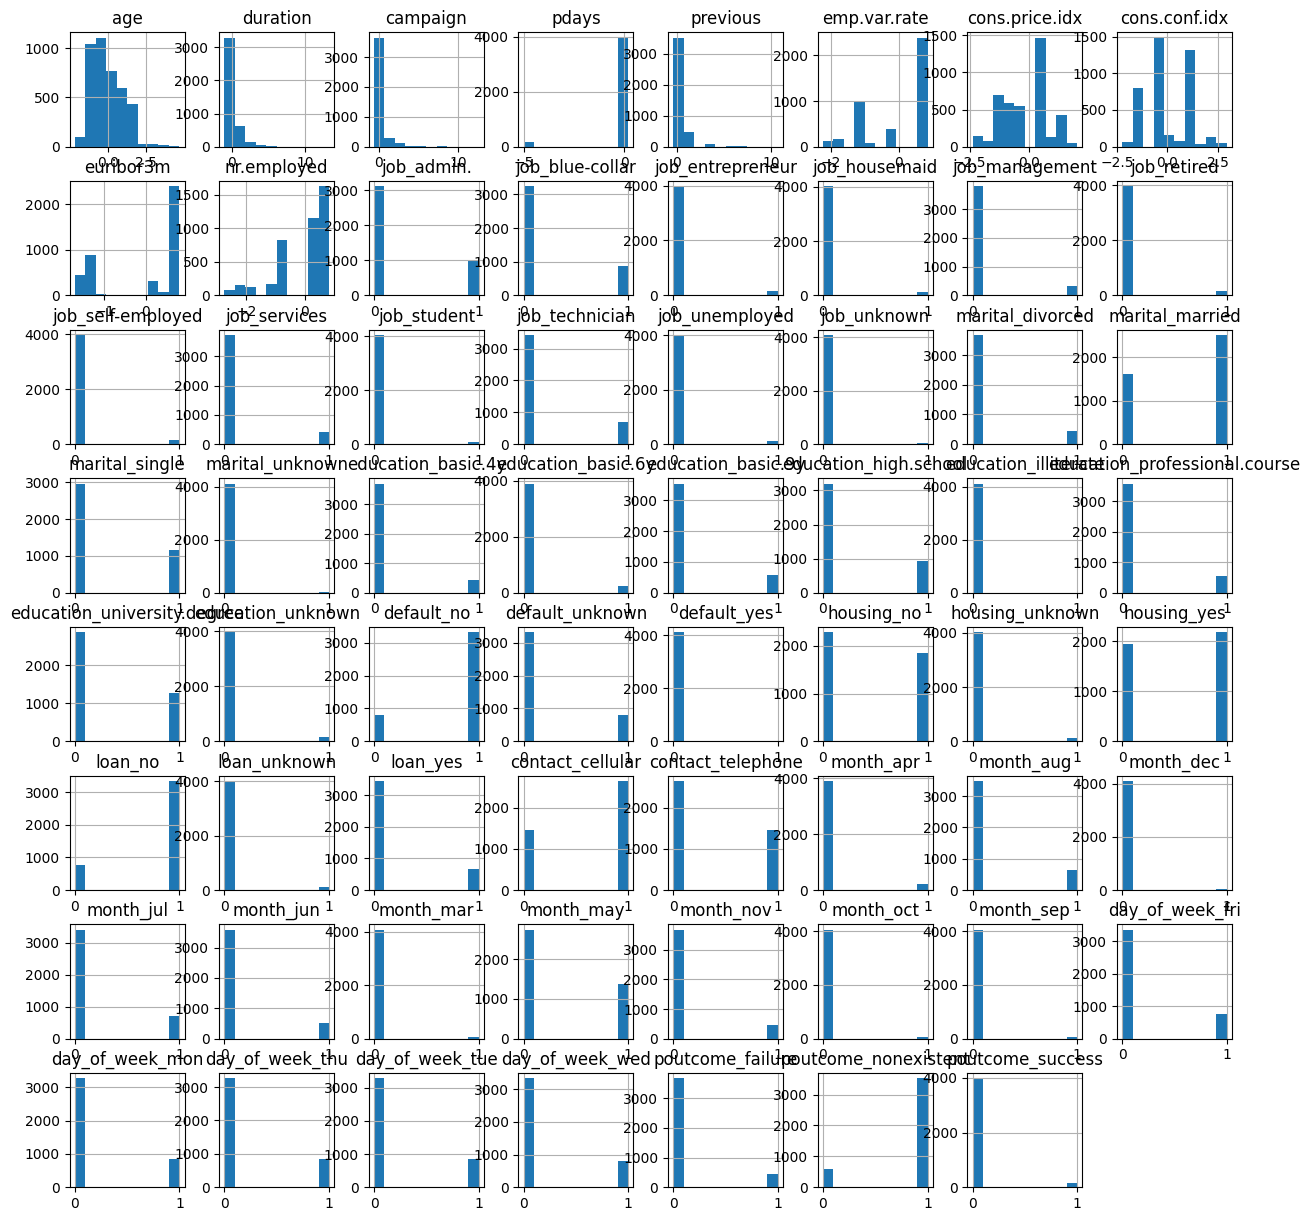

In [3]:
# Your code here
X.hist(figsize=(15,15))
plt.show()

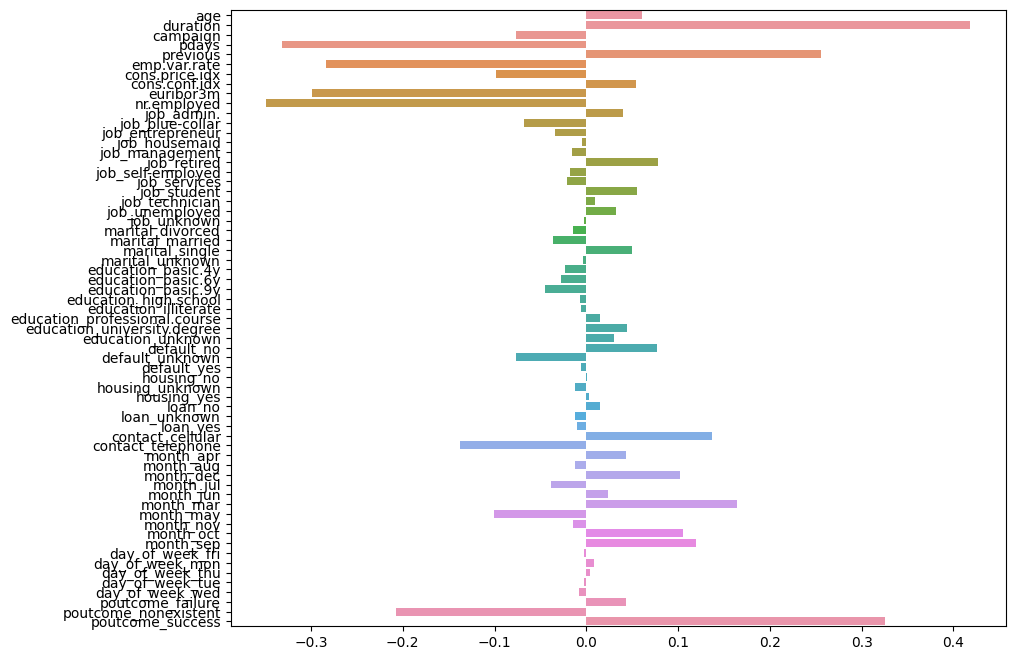

In [4]:
# Your code here
corr_matrix = pd.concat([X, y], axis=1).corr()
corr_with_target = corr_matrix.iloc[:-1, -1]
fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index, ax=ax)
plt.show()

**What are your takeways from the exploratory data analysis?**

(Edit this cell and add your answer)




### 4. Split the data into a stratified 80/20 train/test split.

In [5]:
# Your code here
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### 5. Apply feature selection

Use the following feature selection methods:
1. Filter: Variance Threshold with a threshold of 0.1
2. Embedded: Use the LASSO L1 penalty in the LogisticRegressionCV and keep the features with non-zero coefficients
3. Wrapper: Use Recursive Feature Elimination (RFECV) with Logistic Regression as the estimator.
4. Feature Extraction: Use PCA to extract the top 20 components

For the first three feature selection methods, print out the names of the features that were selected.

**Note:** Since this is an imbalanced dataset using the default scoring criterion, which is classification Accuracy, will not yield good results. For that reason, you should use the F1-Score (`scoring='f1'`) whenever you fit a classifier.

In [6]:
# Your code here

# Variance Threshold with a threshold of 0.1
sel = VarianceThreshold(threshold=0.1)
X_train_sel = sel.fit_transform(X_train)
X_test_sel = sel.transform(X_test)
print("Selected Features using Variance Threshold:", X_train.columns[sel.get_support()])

# Embedded: L1 penalty in the LogisticRegressionCV
clf = LogisticRegressionCV(Cs=10, penalty='l1', solver='liblinear', cv=5, max_iter=1000, scoring='f1')
clf.fit(X_train, y_train)
coef = clf.coef_
print("Selected Features using L1 penalty in LogisticRegressionCV:", X_train.columns[coef[0]!=0])

# Wrapper: Recursive Feature Elimination with Logistic Regression as the estimator
estimator = LogisticRegression(solver='liblinear', max_iter=1000)
selector = RFECV(estimator, cv=5, scoring='f1')
selector.fit(X_train, y_train)
print("Selected Features using Recursive Feature Elimination with Logistic Regression:", X_train.columns[selector.support_])

# Feature Extraction: PCA to extract the top 20 components
pca = PCA(n_components=20)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
print("Top 20 PCA Components:", pca.explained_variance_ratio_)

Selected Features using Variance Threshold: Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed',
       'job_admin.', 'job_blue-collar', 'job_technician', 'marital_married',
       'marital_single', 'education_basic.9y', 'education_high.school',
       'education_professional.course', 'education_university.degree',
       'default_no', 'default_unknown', 'housing_no', 'housing_yes', 'loan_no',
       'loan_yes', 'contact_cellular', 'contact_telephone', 'month_aug',
       'month_jul', 'month_jun', 'month_may', 'month_nov', 'day_of_week_fri',
       'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue',
       'day_of_week_wed', 'poutcome_failure', 'poutcome_nonexistent'],
      dtype='object')
Selected Features using L1 penalty in LogisticRegressionCV: Index(['duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'nr.employed', 'job_admin.',
    

### 6. Fine Tune a Classification Algorithm

We will use the `GradientBoostingClassifier` which is know to be one of the most powefull ensemble algorithms. Some of the hyperparameters that can be tuned when training a GradientBoostingClassifier are:
- Number of estimators (trees): try 100, 200, 300
- Learning rate: try 0.01, 0.1
- Max (tree) depth: try 3, 4

Use `GridSearchCV` to train your classifier for the different hyperparameter values. Remember to use F1-score as your scoring criterion.

Tune your model on the features selected by each one of the methods above.

In [7]:
# Your code here
# Define the hyperparameters to search over
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 4]
}

# Define the classifier
gb = GradientBoostingClassifier()

# Use GridSearchCV to search over the hyperparameters
grid_search = GridSearchCV(gb, param_grid, scoring='f1', cv=5)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and F1-score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best F1-score: ", grid_search.best_score_)

Best hyperparameters:  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best F1-score:  0.5368544890279265


### 7. Evaluate your tuned models on the test data

For each one of the tuned models, print out the following metrics:
- Accuracy
- Precision
- Recall
- F1-Score
- ROC-AUC

For the model that produces the best f1-score, print out the confusion matrix and classification report using the skearn `classification_report` function.


In [8]:
# Your code here
variance_threshold_model = Pipeline([
    ('variance_selector', VarianceThreshold(threshold=0.1)),
    ('classifier', GradientBoostingClassifier(random_state=42))
])
X_train_vt = sel.transform(X_train)
variance_threshold_model.fit(X_train_vt, y_train)
X_test_vt = sel.transform(X_test)


lasso_model = LogisticRegressionCV(penalty='l1', solver='liblinear', cv=5, max_iter=1000, scoring='f1')
lasso_model.fit(X_train_vt, y_train)
X_test_lasso = sel.transform(X_test)

rfecv_model = Pipeline([
    ('scale', StandardScaler()),
    ('feature_selection', RFECV(LogisticRegressionCV(scoring='f1'), cv=5)),
    ('classification', GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=4, random_state=42))
])

# Fit the pipeline on the training data
rfecv_model.fit(X_train, y_train)

pca = PCA(n_components=20)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
pca_model = GradientBoostingClassifier(n_estimators=300, learning_rate=0.1, max_depth=4, random_state=42)
pca_model.fit(X_train_pca, y_train)



# Define a function to print out the evaluation metrics for a given model and dataset
def evaluate_model(model, X, y):
    model.fit
    y_pred = model.predict(X)
    print("Accuracy:", accuracy_score(y, y_pred))
    print("Precision:", precision_score(y, y_pred))
    print("Recall:", recall_score(y, y_pred))
    print("F1-Score:", f1_score(y, y_pred))
    print("ROC-AUC Score:", roc_auc_score(y, y_pred))

    print("Classification Report:")
    print(classification_report(y, y_pred))

# Evaluate the tuned models on the test data
print("Evaluation metrics for the Variance Threshold model:")
evaluate_model(variance_threshold_model, X_test_vt, y_test)

print("Evaluation metrics for the LASSO model:")
evaluate_model(lasso_model, X_test_lasso, y_test)

print("Evaluation metrics for the RFECV model:")
evaluate_model(rfecv_model, X_test, y_test)

print("Evaluation metrics for the PCA model:")
evaluate_model(pca_model, X_test_pca, y_test)

models = [
    ("Variance Threshold", variance_threshold_model),
    ("Lasso", lasso_model),
    ("RFECV", rfecv_model),
    ("PCA", pca_model)
]

# Print out the best model based on F1-score
print("\nBest model based on F1-score:")
f1_scores = []
for name, model in models:
    kfold = KFold(n_splits=4, random_state=42, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='f1')
    f1_scores.append(cv_results.mean())


best_idx = np.argmax(f1_scores)
best_name, best_model = models[best_idx]
print(f"\nBest model: {best_name} (F1-score: {f1_scores[best_idx]:.3f})")

# Evaluate the tuned models on the test data
print("\nEvaluation metrics for the PCA model:")
evaluate_model(pca_model, X_test_pca, y_test)

/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

Evaluation metrics for the Variance Threshold model:
Accuracy: 0.912621359223301
Precision: 0.6451612903225806
Recall: 0.4444444444444444
F1-Score: 0.5263157894736842
ROC-AUC Score: 0.7072358462004238
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       734
           1       0.65      0.44      0.53        90

    accuracy                           0.91       824
   macro avg       0.79      0.71      0.74       824
weighted avg       0.90      0.91      0.91       824

Evaluation metrics for the LASSO model:
Accuracy: 0.9150485436893204
Precision: 0.7
Recall: 0.3888888888888889
F1-Score: 0.5
ROC-AUC Score: 0.6842264607932182
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95       734
           1       0.70      0.39      0.50        90

    accuracy                           0.92       824
   macro avg       0.81      0.68      0.73      

/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re


Best model: PCA (F1-score: 0.543)

Evaluation metrics for the PCA model:
Accuracy: 0.8980582524271845
Precision: 0.5555555555555556
Recall: 0.3333333333333333
F1-Score: 0.4166666666666667
ROC-AUC Score: 0.6503178928247048
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.94       734
           1       0.56      0.33      0.42        90

    accuracy                           0.90       824
   macro avg       0.74      0.65      0.68       824
weighted avg       0.88      0.90      0.89       824



### 8. Discuss your results

**What are your main takeaways from this assignment?**
The main takeaways from this assignment is data preprocessing, model selection and evaluation and error handling. The biggest part of the assignment was to use the different models and select which one worked best with the data based on the F-1 Score. 
The next big thing was the error handling that I had to work through. I had plenty of problems with X_test not being the right size for each one and always running out of space.